# Práctica Rectas

### Importo Librerias

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import math
import copy
import numpy.linalg as linalg
from scipy.signal import convolve2d
from skimage import color, data
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line, circle_perimeter
import cv2 as cv
from scipy.signal import convolve2d
import glob, os

### Importo imagenes

In [186]:
imgHouse = imageio.imread('img/house.png')
imgLaPlata = imageio.imread('img/color/ruta.jpg')
imgLaPlata = imageio.imread('img/color/ruta.jpg')
imgSeptagon = imageio.imread('img/imagenesHough/septagon.png')
imgTest = imageio.imread('img/imagenesHough/test.png')
imgChess = color.rgb2gray(color.rgba2rgb(imageio.imread('img/imagenesHough/chess.png'))).astype('uint8')
def mostrarImagen(img, cmap=None, norm=False):
    plt.imshow(img, cmap=cmap)
    plt.show()

def calcNivelesGrises(img):
    return np.iinfo(img.dtype).max+1

In [14]:
def scale(v, beginBefore, endBefore, beginAfter, endAfter):
    v_ = abs(v-beginBefore)
    lenRange1 = abs(endBefore-beginBefore)
    lenRange2 = abs(endAfter-beginAfter)
    return beginAfter+v_/lenRange1*lenRange2

In [25]:
def aplicarRuidoGaussiano(img, a=0, b=30):
    imgCopy = copy.deepcopy(img)
    for i in range(len(img)):
        for j in range(len(img[0])):
            imgCopy[i][j] += int(a + (b-a)*np.random.normal(0,1))
    return imgCopy

def aplicarFiltroGaussiano(img, n, sigma=5):
    m = np.zeros((n,n))
    for i in range(len(m)):
        for j in range(len(m)):
            dx = n//2-i
            dy = n//2-j
            m[i][j] = math.e**(-(dx**2+dy**2)/(2*sigma**2))
    return convolve2d(img, m/np.sum(m), mode='same')

# Ejercicio 1

In [198]:
def nonMaxSupression(img, n=5, num_peaks=5):
    imgCopy = np.zeros((len(img),len(img[0])))
    for i in range(0,len(img)-n,n):
        for j in range(0,len(img[0])-n,n):
            points = []
            for h in range(n):
                for z in range(n):
                    if img[i+h][j+z] > 0:
                        points.append([i+h,j+z,img[i+h][j+z]])

            points.sort(key=lambda x:x[2],reverse=True)
            num = 0
            for p in points:
                imgCopy[p[0],p[1]] = 255
                num += 1
                if num == num_peaks:
                    break
    return imgCopy


def detectCorners(img, n=6, threshold=0.5):
    sobelX = np.array([[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]])
    sobelY = np.array([[1, 2, 1],
                [0, 0, 0],
                [-1, -2, -1]])

    dx = convolve2d(img, sobelX, mode='same')
    dy = convolve2d(img, sobelY, mode='same')
    dxy = dx * dy

    Sx = aplicarFiltroGaussiano(dx,10,100)
    Sy = aplicarFiltroGaussiano(dy,10,100)
    Sxy = aplicarFiltroGaussiano(dxy,10,100)

    imgCopy = np.zeros((len(img),len(img[0])))
    for i in range(n//2,len(img)-n//2):
        for j in range(n//2,len(img[0])-n//2):
            sH, sW, eH, eW = i-n//2, j-n//2, i+n//2, j+n//2 
            _Sx = Sx[sH:sH+n//2,sW:sW+n//2]
            _Sxy = Sxy[eH+n//2:eH,sW:sW+n//2]
            _Sxy = Sxy[sH:sH+n//2,sW+n//2:eW]
            _Sy = Sy[sH+n//2:eH,sW+n//2:eW]

            M = np.hstack((np.vstack((_Sx,_Sxy)),np.vstack((_Sxy,_Sy))))
            values, vectors = linalg.eig(M)
            imgCopy[i][j] = linalg.det(M) - 0.04*(np.trace(M)**2)

    #for i in range(len(img)):
    #   for j in range(len(img[0])):
    #        if img[i,j] < threshold:
    #            imgCopy[i,j] = 0

    return nonMaxSupression(imgCopy)

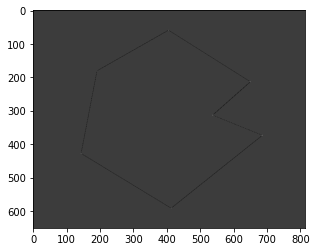

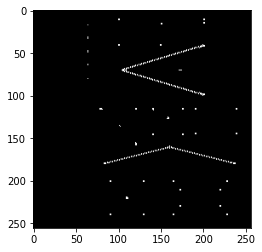

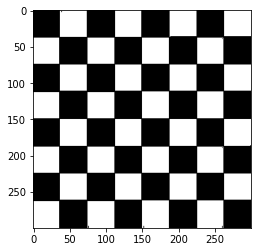

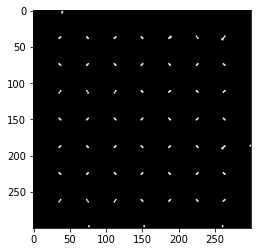

In [187]:
mostrarImagen(cv.cornerHarris(imgSeptagon,2,3,0.04),cmap='gray')
mostrarImagen(cv.cornerHarris(imgTest,2,3,0.04) > 0.000001,cmap='gray')
mostrarImagen(imgChess,cmap='gray')
mostrarImagen(cv.cornerHarris(imgChess,2,3,0.04) > 1e-20,cmap='gray')

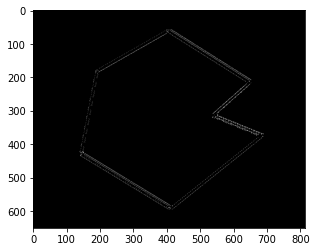

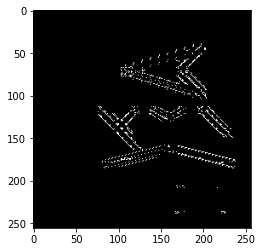

In [201]:
mostrarImagen(detectCorners(imgSeptagon, threshold=0.1),cmap='gray')
mostrarImagen(detectCorners(imgTest, threshold=1e-6),cmap='gray')

# Ejercicio 2

La imagen (c) se corresponde con la (I) porque es la única imagen con 5 puntos y (I) tiene 5 líneas  

La imagen (a) se corresponde con la (II) porque la linea que pasa por más puntos es la de 45grados empezando desde la esquina abajo y en (II) vemos que el punto donde van 3 curvas es en 45grados.  

La imagen (b) se corresponde con la (III).

# Ejercicio 3

In [128]:
def getAcum3dHoughCircular(cannyImg, acurracyY=None, acurracyX=None, acurracyR=None):
    
    maxDimension = max(len(cannyImg),len(cannyImg[0]))
    radios = np.linspace(10, 600, 15)
    acum3d = np.zeros((len(cannyImg),len(cannyImg[0]),len(radios)))

    titas = np.linspace(-np.pi/2,np.pi/2,30)

    print(np.shape(acum3d))
    
    for i in range(len(cannyImg)):
        for j in range(len(cannyImg[0])):
            if cannyImg[i,j] > 0: #Estamos en un borde
                for idxR, r in enumerate(radios):
                    #b = round(j - r * np.sin(tita))
                    #a = round(i - r * np.cos(tita))
                    rr, cc = circle_perimeter(i, j, int(r),shape=np.shape(cannyImg))
                    acum3d[rr,cc,idxR] += 1

    return acum3d, radios

def drawCircles(img, circles):
    imgColor = copy.deepcopy(img)
    if len(np.shape(img)) == 2: #es escala grises, pasamos a color
        imgColor = color.gray2rgb(img)

    for v in circles:
        rr, cc = circle_perimeter(v[0], v[1], int(v[2]), shape=np.shape(img))
        imgColor[rr, cc] = np.array([255,0,0])

    return imgColor

def filterCircles(acum3d, radios, threshold=0.5, num_peaks=10):
    circles = []
    max = acum3d.max()
    for i in range(len(acum3d)):
        for j in range(len(acum3d[0])):
            for h in range(len(acum3d[0][0])):
                if acum3d[i,j,h] > threshold*max:
                    circles.append([i,j,radios[h],acum3d[i,j,h]])

    circles.sort(key=lambda z: z[3],reverse=True)
    return circles[:num_peaks]

def detectEyes(img):
    imgForCanny = img
    if len(np.shape(img)) > 2: #es color, pasamos a escala de grises
        imgForCanny = color.rgb2gray(img)

    cannyImg = canny(imgForCanny)
    acum3d, radios = getAcum3dHoughCircular(cannyImg)
    circles = filterCircles(acum3d, radios)
    return drawCircles(img, circles)


In [39]:
imagesIris = []
for f in glob.glob('img/iris/*.jpg'):
    img = imageio.imread(f)
    outFile = os.path.splitext(f)[0]+'-out.jpg'
    imageio.imwrite(outFile, detectEyes(img))

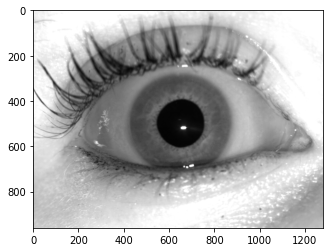

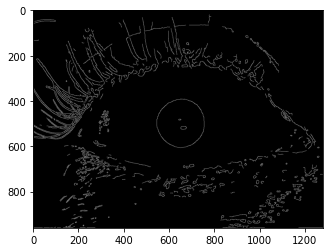

(960, 1280, 15)


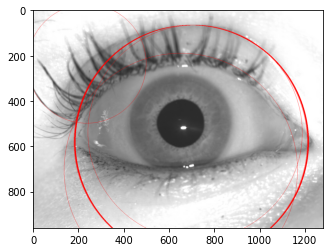

In [129]:
for f in imagesIris:
    mostrarImagen(f,cmap='gray')
    mostrarImagen(canny(f),cmap='gray')
    mostrarImagen(detectEyes(f))
    break

# Ejercicio 4

In [6]:
def getAcum2dHough(cannyImg, acurracyDegree, acurracyP):
    acum2d = np.zeros((acurracyP,acurracyDegree))
    maxDistanceCenter = math.sqrt(len(cannyImg[0])**2+len(cannyImg)**2)
    titas = np.linspace(-np.pi/2,np.pi/2,len(acum2d[0]))
    #cdef int i, j
    for i in range(len(cannyImg)):
        for j in range(len(cannyImg[0])):
            if cannyImg[i][j] > 0: #Estamos en un borde
                for tita in titas:
                    p = j*math.cos(tita)+i*math.sin(tita)

                    pScaled = round(scale(p, -maxDistanceCenter, maxDistanceCenter, 0, len(acum2d)-1))
                    titaScaled = round(scale(tita, -np.pi/2, np.pi/2, 0, len(acum2d[0])-1))
                    acum2d[pScaled][titaScaled] += 1
    return acum2d


def finalLines(img, vec):
    imgColor = copy.deepcopy(img)
    if len(np.shape(img)) == 2: #es escala grises, pasamos a color
        imgColor = color.gray2rgb(img)

    for v in vec:
        #v[0] -> p, v[1] -> tita
        if v[1] != 0:
            y0 = v[0]/math.sin(v[1]) #x = 0
            y1 = (v[0]-len(imgColor[0])*math.cos(v[1]))/math.sin(v[1]) #x = w
            rr, cc = line(round(y0), 0, round(y1), len(imgColor[0]))
            for i in range(len(rr)):
                if rr[i] < len(imgColor) and rr[i] >= 0 and cc[i] < len(imgColor[0]) and cc[i] >= 0:
                    imgColor[rr[i], cc[i]] = np.array([255,0,0])

    return imgColor


def filterLines(acum2d, threshold, imgW, imgH, min_dist, min_angle, num_peaks):
    rectas = []
    max = acum2d.max()
    maxDistanceCenter = math.sqrt(imgW**2+imgH**2)
    min_dist *= maxDistanceCenter
    acum2dFlatOrdered = np.flip(np.argsort(np.reshape(acum2d,-1)))

    for i in acum2dFlatOrdered:
        indexY = i//len(acum2d[0])
        indexX = i%len(acum2d[0])

        if acum2d[indexY][indexX] < max*threshold:
            break
        

        tita = scale(indexX, 0, len(acum2d[0]), -np.pi/2, np.pi/2)
        p = scale(indexY, 0, len(acum2d), -maxDistanceCenter, maxDistanceCenter)
        rectas.append([p,tita,acum2d[indexY][indexX]])

    ''' #FORMA CORRECTA PERO MAS LENTA EN PYTHON DE HACERLO
    for i in range(len(acum2d)):
        for j in range(len(acum2d[0])):
            if acum2d[i][j] > max*threshold:
                tita = scale(j, 0, len(acum2d[0]), -np.pi/2, np.pi/2)
                p = scale(i, 0, len(acum2d), -maxDistanceCenter, maxDistanceCenter)
                rectas.append([p,tita,acum2d[i][j]])
    '''

    rectas.sort(reverse=True)
    i = 0
    while i < len(rectas):
        j = i+1
        while j < len(rectas):
            if abs(rectas[i][1] - rectas[j][1]) < min_angle/180*np.pi and abs(rectas[i][0] - rectas[j][0]) < min_dist:
                if rectas[i][2] < rectas[j][2]:
                    del rectas[i]
                    i -= 1
                    break
                else:
                    del rectas[j]
                    j -= 1
            elif i > 0 and abs(rectas[i][0] - rectas[j][0]) > min_dist:
                break
            j+=1
        i+=1
    
    rectas.sort(key=lambda x : x[2], reverse=True)
    return rectas[:num_peaks]
    

def houghLineas(img, threshold=0.5, num_peaks=6, min_dist=0.4, min_angle=15, acurracyDegree=180, acurracyP=None, fast=False):
    imgForCanny = img
    if len(np.shape(img)) > 2: #es color, pasamos a escala de grises
        imgForCanny = color.rgb2gray(img)

    cannyImg = canny(imgForCanny)
    acum2d = None
    if fast:
        acum2d, angles, dist = hough_line(cannyImg)
    else:
        if acurracyP == None:
            acurracyP = math.ceil(2*math.sqrt(len(cannyImg)**2+len(cannyImg[0])**2))
        acum2d = getAcum2dHough(cannyImg, acurracyDegree, acurracyP)
    
    rectas = filterLines(acum2d, threshold, len(img[0]), len(img), min_dist, min_angle, num_peaks)

    return finalLines(img, rectas)
    

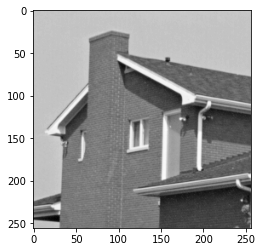

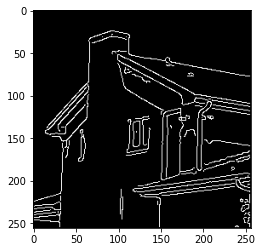

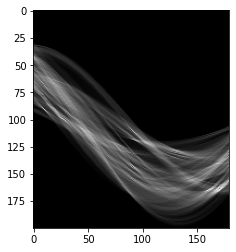

In [9]:
mostrarImagen(imgHouse, cmap='gray')
mostrarImagen(canny(imgHouse), cmap='gray')
mostrarImagen(getAcum2dHough(canny(imgHouse), 180, 200), cmap='gray')

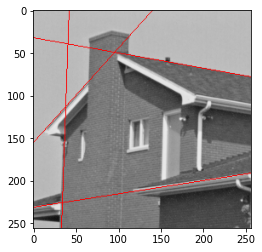

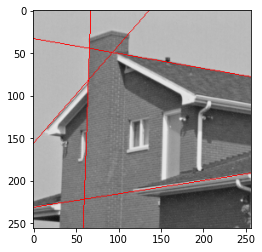

In [10]:
mostrarImagen(houghLineas(imgHouse,threshold=0.5, num_peaks=5, min_dist=0.3, min_angle=20,fast=True))
mostrarImagen(houghLineas(imgHouse,threshold=0.5, num_peaks=5, min_dist=0.3, min_angle=20,fast=False))

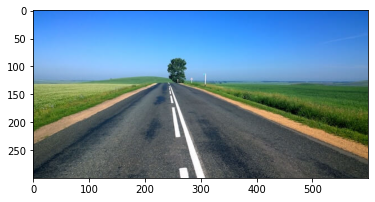

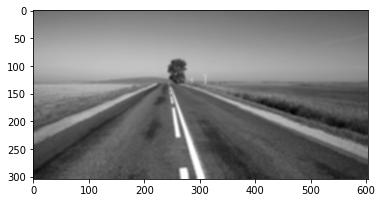

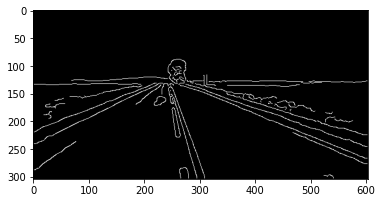

In [59]:
mostrarImagen(imgLaPlata)
mostrarImagen(convolve2d(color.rgb2gray(imgLaPlata), gaussKernel(5,10), boundary='symm'), cmap='gray')
mostrarImagen(canny((color.rgb2gray(imgLaPlata), gaussKernel(5,10),boundary='symm')), cmap='gray')

In [11]:
def fastHoughLineas(img, smooth=None, threshold=1.3):
    imgForCanny = img
    if len(np.shape(img)) > 2: #es color, pasamos a escala de grises
        imgForCanny = color.rgb2gray(img)
    if smooth != None:
        imgForCanny = convolve2d(imgForCanny, gaussKernel(smooth['n'],smooth['sigma']), boundary='symm',mode='same')
    cannyImg = canny(imgForCanny)
    acum2d, angles, dist = hough_line(cannyImg)
    peak_values, angles, dist = hough_line_peaks(acum2d, angles, dist, threshold=threshold, num_peaks=5)
    max = acum2d.max()

    rectas = []
    for i in range(len(angles)):
        rectas.append([dist[i],angles[i]])

    return finalLines(img, rectas)

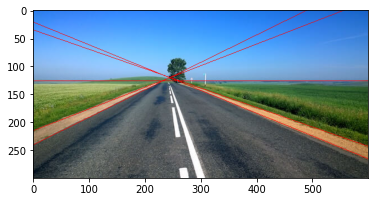

In [289]:
mostrarImagen(fastHoughLineas(imgLaPlata, smooth={'n':5,'sigma':10}, threshold=2))

In [11]:
from IPython.display import clear_output
import time


def houghLinesVideo(nameInput, nameOutput):
    cap = cv.VideoCapture(nameInput)
    h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    fps = cap.get(cv.CAP_PROP_FPS)
    out = cv.VideoWriter(nameOutput, -1, fps, (w,h))

    frameNumber = 0
    length = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    start_time = time.time()

    while cap.isOpened():
        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        frameNumber += 1
        clear_output(wait=True)
        print(f'{frameNumber}/{length}')

        print("Tiempo Estimado: "+str(round((time.time() - start_time)/60*(length-frameNumber)))+  "minutos")
        start_time = time.time()

        frameRGB = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        finalFrame = houghLineas(frameRGB,threshold=0.5, num_peaks=6, min_dist=0.4, min_angle=15, fast=True)
        #mostrarImagen(finalFrame)
        out.write(cv.cvtColor(finalFrame,cv.COLOR_RGB2BGR))
        
        if cv.waitKey(1) == ord('q'):
            break
    cap.release()
    out.release()

In [12]:
houghLinesVideo('videos/camino1.mp4', 'videos/camino1-out2.mp4')
houghLinesVideo('videos/camino2.mp4', 'videos/camino2-out2.mp4')

1453/1453
Tiempo Estimado: 0minutos
Can't receive frame (stream end?). Exiting ...
